#  EMA for Aperiodic Quotes

## Introduction

Background on the simple moving average (SMA) and exponential moving average (EMA) is available on [Wikipedia](https://en.wikipedia.org/wiki/Moving_average).  The discussion there references the number of periods, $n$, of a moving average.  The period is the fixed time-interval between new input data samples: daily, hourly, ...

In many applications quotes are updated as changes in an order book occur and are therefore *aperiodic*.  The new inputs are not available at fixed time steps, and the number of periods, $n$, is not meaningful.  One approach to moving averages with aperiodic inputs is to resample the input data stream periodically.  That works, but it also introduces a lag between the arrival of new data and computation of an updated EMA value.

This notebook derives and demonstrates the algorithm to update the EMA for an aperiodic data stream without resampling.

Loosely echoing Wikipedia notation, the periodic EMA is:
$$S_{j+1} = S_j + k \cdot (Y_{j+1} - S_j) $$

where:  
$S_j$ is the EMA estimate at step $j$  
$Y_j$ is the new data at step $j$  
$k$ is the EMA gain.

$$ k = \frac 2{n+1} $$
where $n$ is the number of periods.

The gain, $k$, is derived by equating the first moment of the sum of the weights from the EMA with that of an $n$-period SM.  It defines an EMA in which the weighted-average age of the data used in the EMA is the same as that of an $n$-period SMA. 

## Background - Exponential Decay

The EMA weights are derived from the exponential decay model.  A signal or process with exponential decay from an initial value at time zero follows this trajectory:

$$ z(t)= z(0) \cdot e^{\frac {-t}{\tau}} $$

The value $\tau$ is the time constant of the exponential decay.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

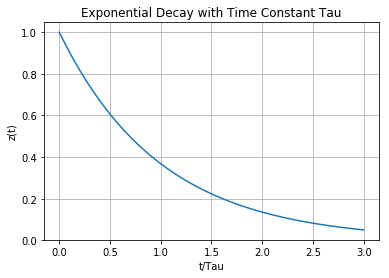

In [2]:
t=np.linspace(0.0,3.0,301)
decay = np.exp(-t)
plt.plot(t,decay)
plt.xlabel('t/Tau')
plt.ylabel('z(t)')
plt.title('Exponential Decay with Time Constant Tau')
plt.grid()

Some points from this curve are tabulated below.

| t/$\tau$ |  z(t)  |  %  |
|-------|--------|-----|
|   0   |    1   | 100 |
|   1   | 0.3679 |  37 |
|   2   | 0.1353 |  14 |
|   3   | 0.0498 |   5 |

After an elapsed time of one time constant (t/$\tau$ = 1), the original signal is down to 37% of its initial value.

## Exponential-Weight MA

We can express the weights of an exponential moving average as a function of time, and we will need to for the aperiodic EMA.  Assuming we want to model weight decay with time constant $\tau$ we then have the function $z(t)$ above to define the weight as a function of elapsed time.  So we can write down a time-based EMA update equation by using $z(\Delta t)$ for weighting prior data.

$$ S_{(t+\Delta t)} = (1-z(\Delta t)) \cdot Y_{(t+\Delta t)} + z(\Delta t) \cdot S_{(t)} $$

We can rearrange this as:
$$ S_{(t+\Delta t)} = S_{(t)} + (1-z(\Delta t)) \cdot (Y_{(t+\Delta t)} - S_{(t)}) $$

We recall the periodic financial EMA from above is:
$$S_{j+1} = S_j + k \cdot (Y_{j+1} - S_j) $$

For $\Delta$t fixed, the two are the same if we let 
$$k=1-z(\Delta t)=1-e^{\frac {-\Delta t}{\tau}}$$

We have arranged the two forms of the fixed-interval EMA to look the same, but they use different gains. The aperidic gain, $k_A$ and the periodic gain $k_P$.
$$k_A = 1 - e^{\frac {-\Delta t}{\tau}}  \\
k_P = \frac 2{n+1} $$,

To relate time constant $\tau$ to number of periods $n$ we can set the gains equal and solve for $\tau$.

$$ 1 - e^{\frac {-\Delta t}{\tau}} = \frac 2{n+1} $$

$$ - e^{\frac {-\Delta t}{\tau}} = \frac {2-n-1}{n+1} $$

$$ e^{\frac {-\Delta t}{\tau}} = \frac {n-1}{n+1} $$

$$ \frac {-\Delta t}{\tau} = \log {\frac {n-1}{n+1}} $$

$$ \frac {1}{\tau} = \frac {1}{-\Delta t} \cdot \log {\frac {n-1}{n+1}} $$

$$ {\tau} = {-\Delta t} \cdot \frac {1}{\log {\frac {n-1}{n+1}}} $$

It's not obvious what that looks like, so let's plot it

Text(0.5,1,'Exponential Decay Time Constant vs Number of Periods')

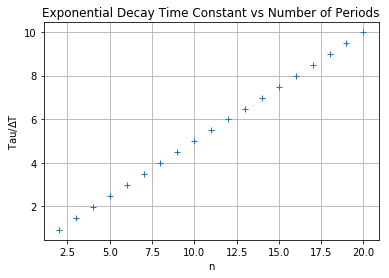

In [3]:
n=np.linspace(2,20,19)
plt.plot(n,-1/np.log((n-1)/(n+1)),'+')
plt.grid()
plt.xlabel('n')
plt.ylabel('Tau/$\Delta$T')
plt.title('Exponential Decay Time Constant vs Number of Periods')

Clearly linear, so let's divide the time constant by $n$ to see the coefficient.

Text(0.5,1,'(Time Constant / n) vs n')

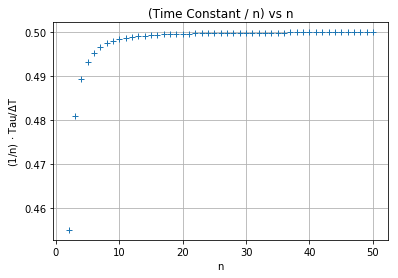

In [4]:
n=np.linspace(2,50,49)
plt.plot(n,-1/np.log((n-1)/(n+1))/n,'+')
plt.grid()
plt.xlabel('n')
plt.ylabel('(1/n) $\cdot$ Tau/$\Delta$T')
plt.title('(Time Constant / n) vs n')

So we can now put together the relationship of the gains.  We know the explicit relationship between the number of periods and the exponential decay time constant is:
$$ {\tau} = {-\Delta t} \cdot \frac {1}{\log {\frac {n-1}{n+1}}} $$
However, we can see this relationship is asymptotically approaching
$$ \frac {\tau}{\Delta t \cdot n} \approx 0.5$$
or
$$ 2 \tau \approx n \Delta t $$

So, the $n$-period EMA is approximately equal to a time-based EMA with $n$ quote intervals equal to twice the decay time constant.

The physicist's EMA is a time-based equation, not a step-based equation.  We can use it for arbirary time-steps, the only wrinkle being we must compute the gain anew for each time-step.  We have two ways to compute this gain from the typical financial EMA parameters ($n$,$\Delta t$).  The first is exact, the second approximate.

## Example Periodic vs Aperiodic EMA

To check this we'll compare a periodic and aperiodic EMA from the same truth signal and see how they compare.  First we'll make a 20-period EMA of a sine wave.

In [5]:
Pts = 200
n=20

In [6]:
tPer = np.linspace(0.0,2.0*np.pi,Pts)

In [7]:
yPer = np.sin(tPer)

In [8]:
sPer = np.zeros(len(yPer))
sPer[0] = yPer[0]

In [9]:
kPer = 2.0 / (n + 1)

In [10]:
for i in range(1,Pts):
    sPer[i] = sPer[i-1] + kPer * (yPer[i] - sPer[i-1])

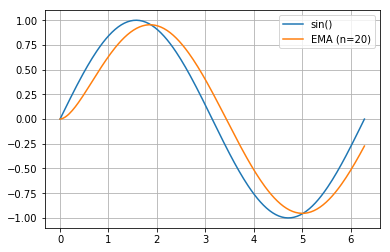

In [11]:
plt.plot(tPer,yPer)
plt.plot(tPer,sPer)
plt.legend(['sin()','EMA (n=20)'])
plt.grid()

### Now we will compute the EMA from aperidic samples

Pick random sample times and sort them

In [13]:
t=(2.0 * np.pi * np.random.rand(Pts))

In [14]:
t.sort()

In [15]:
y=np.sin(t)

In [16]:
s=np.zeros(Pts)
k=np.zeros(Pts)

In [17]:
s[0] = y[0]

We compute the time constant for the time-based aperiodic EMA from the number of periods and time step size of the periodic EMA we want to match.

In [18]:
tau = - tPer[1] / np.log((n-1)/(n+1))

This time constant is fixed, but the gain used in each step of the EMA update *does* vary with the size of the aperodic time-step.

In [19]:
for i in range(1,Pts):
    dt = t[i] - t[i-1]
    k[i] = 1.0 - np.exp(-dt/tau)
    s[i] = s[i-1] + k[i] * (y[i] - s[i-1])

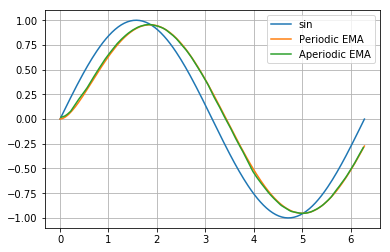

In [20]:
plt.plot(tPer,yPer)
plt.plot(tPer,sPer)
plt.plot(t,s)
plt.grid()
plt.legend(['sin','Periodic EMA','Aperiodic EMA'])

This works as it should.  The aperiodic EMA computed from random samples times matches the periodic EMA.